# Help dr. Vasilescu

Help dr. Vasilescu establish a more stable communication with Earth by implementing Computed Torque Control on the AL5D robot.

# Proposed problems

  1. Consider the same AL5D_mdw robot. Implement a Computed Torque Control with state feedback controllers and an outer loop integrator.
  2. Make some small changes in the model estimation (so not the real model) to check if the controller is still able to keep good performance.

For the first exercise, there are some steps to be taken into consideration. 

We first have to eliminate the nonlinear element from the model. In order to do that, we remodel the equation of the torques using the D and V matrices (figure 11.6 and 11.7), which will later linearize the system. For that, we can just define 2 functions that would take the positions and velocities as input and return their respective terms (the following code cell).
    
<br>

<center>
    <figure class="image">
      <img src="Control_3_2.png" width=50% />
      <figcaption>Figure 11.6: D term </figcaption>
    </figure>
</center>

<center>
    <figure class="image">
      <img src="Control_3_1.png" width=50% />
      <figcaption>Figure 11.7: V term </figcaption>
    </figure>
</center>

In [1]:
# model estimation
# run this cell in order to load the functions in the workspace

def Dterm(rob, x, a):
    """ function computing the D term = D*acceleration vector"""
      
    q  = x[:,0]  #first column of x, the states
    dq = x[:,1]  #second column of x, the states derivated

    D = rob.inertia(q)
    
    return D@a

def Vterm(rob, x):
    """ function computing the V term = C*velocity vector + G"""

    q  = x[:,0]  #first column of x, the states
    dq = x[:,1]  #second column of x, the states derivated

    C = rob.coriolis(q, dq)
    G = rob.gravload(q).reshape(1,5)
    
    return (C@dq).reshape(1,5) + G

After that, since we have a linearised system, we can try to just use a state feedback controller (with the error and error derivatives as states) for the inner control loop (fig. 11.8) and an integrator term for the outer control loop(fig. 11.9).


<center>
    <figure class="image">
      <img src="Control_3_3.png" width=50% />
      <figcaption>Figure 11.8: Inner loop controller </figcaption>
    </figure>
</center>

<center>
    <figure class="image">
      <img src="Control_3_4.png" width=50% />
      <figcaption>Figure 11.9: Outer loop controller </figcaption>
    </figure>
</center>

In [16]:
import roboticstoolbox as rtb
from roboticstoolbox import *
import numpy as np
import matplotlib.pyplot as plt
from math import pi 
from scipy.integrate import odeint
import math as m
from odeintw import *
from spatialmath import *
from spatialmath.base import *
from scipy.signal import place_poles
from lab_functions import *

# plt.style.use('rcs.mplstyle')

# load the robot in workspace
rob = rtb.models.DH.AL5D_mdw()

# real model
def model(x,t,tau):
    g  = 9.8
  
    tau = tau.reshape(5,1) # reshaping for mathematical operations

    q  = x[:,0]  #first column of x, the states
    dq = x[:,1]  #second column of x, the states derivated

    G = rob.gravload(q).reshape(5,1)
    D = rob.inertia(q)
    C = rob.coriolis(q, dq)

    xdot1 = dq.reshape(5,1)
    xdot2 = np.matmul(np.linalg.inv(D), (tau - C.dot(dq).reshape(5,1) - G))
    
    xdot = np.concatenate((xdot1, xdot2), axis=1)

    return xdot

# time interval/sampling time
dt = 0.01

# final time
tf = 3

# nr of samples
n = int(np.round(tf/dt)) # 100 samples

# Desired time samples for the solution.
t = np.arange(0, tf, dt)

# trajectory planning
sp_q   = 0.5*np.sin(t)
dsp_q  = 0.5*np.cos(t)
ddsp_q = -sp_q

# x0 is the initial condition of the states
x0 = np.zeros((5,2))

# initialisations
q   = np.zeros((n,5))
dq  = np.zeros((n,5))
ddq = np.zeros((n,5))
tau = np.zeros((n,5))
u   = np.zeros((n,5))
a   = np.zeros((n,5))

# pole placement for inner loop state feedback
# syntax for place_poles from scipy: place_poles(A,B,p)
# where A and B are 2 dimensional arrays taken from the state space representation, p is an array of desired poles
A = np.concatenate([np.concatenate([np.zeros((5,5)), np.identity(5)], axis = 1),
                   np.concatenate([np.zeros((5,5)), np.zeros((5,5))], axis = 1)], axis = 0) # from equation 7
B = np.concatenate([np.zeros((5,5)), np.eye(5)], axis = 0) # from equation 7
p = np.array([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]) #from system theory I, II; array of desired poles
m = 2*n
K = place_poles(A, B, p).gain_matrix

n_joints = rob.n

# Define and tune by hand integrator gain
Ki = 0.5

integrator_term = np.zeros((1,5))

# solve ODE for each step
for i in range(1,n):
    printProgressBar((i + 1) / n, prefix="Progress:", suffix="complete", length=60)

    # span for next time step
    tspan = [t[i - 1], t[i]]
    
    q_current = x0[:, 0]
    dq_current = x0[:, 1]
    
    # calculate total error (integral) for each joint
    error = sp_q[i] - q_current
    error_dot = dsp_q[i] - dq_current
    
    # calculate integrator term as in equation 8
    integrator_term += Ki * error.reshape(1,5) * dt
    
    # calculate state feedback from error and derivative of error as in equation 8
    state_feedback = -K.dot(np.concatenate((error, error_dot), axis=0)).reshape(1,5)

    D = rob.inertia(q_current)
    C = rob.coriolis(q_current, dq_current)
    G = rob.gravload(q_current).reshape(1, 5)
    
    # linearising inner controller as in equation 3
    """
    D_term = Dterm(rob, x0, a[i, :])
    V_term = Vterm(rob, x0)
    tau[i,:] = D_term + V_term  
    """
    
    u[i,:] = integrator_term + state_feedback
    a[i,:] = ddsp_q[i] - u[i,:]
    tau[i, :] = D.dot(a[i,:]) + C.dot(dq_current).reshape(1,5) + G
    
    # solve for next step with initial condition as 2D array
    x = odeintw(model,x0,tspan,args=(tau[i,:],))

    # store solution for plotting
    q[i,:]  = x[1][:,0]
    dq[i,:] = x[1][:,1]
    
    # next initial condition 
    x0 = x[1]

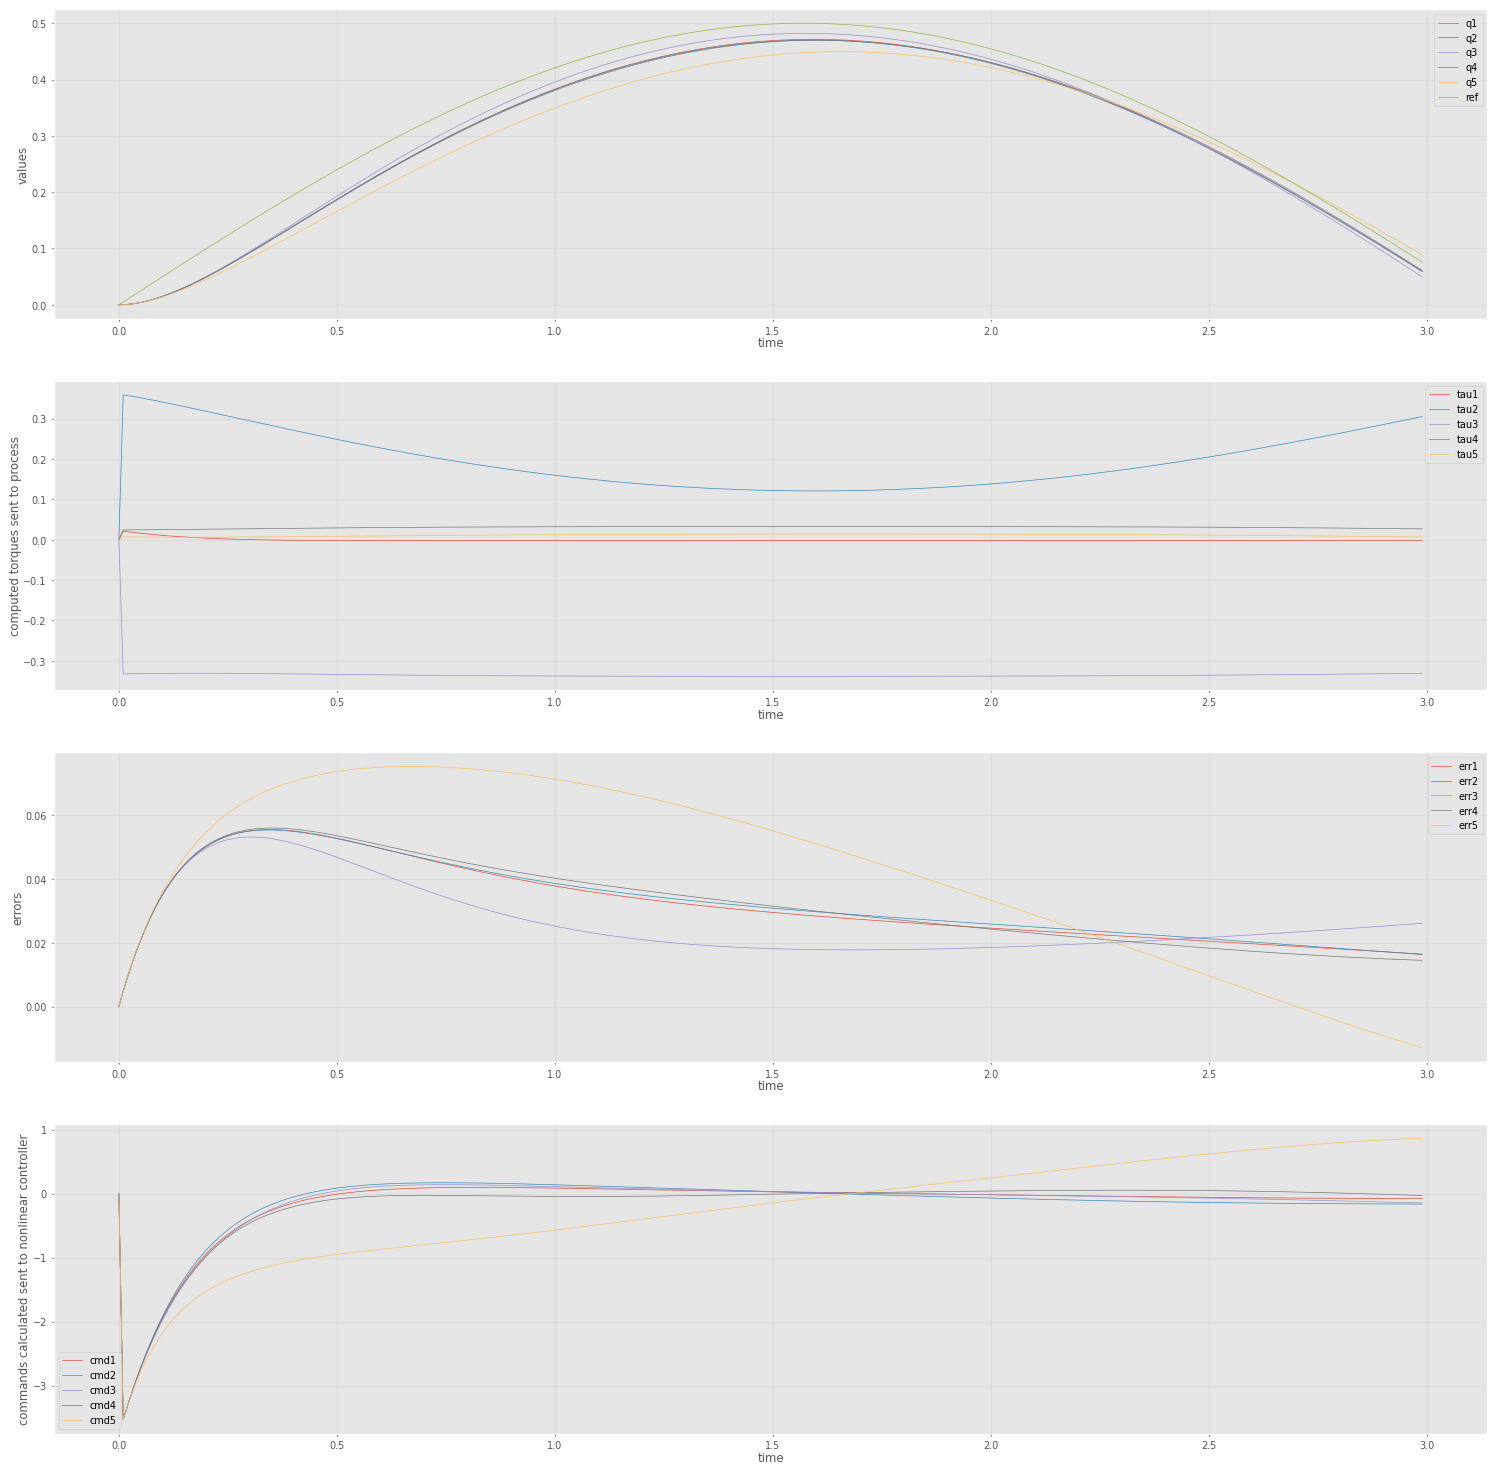

In [17]:
# plt.style.use('rcs.mplstyle')
fig = plt.figure()
fig.set_size_inches(18.5, 18.5)

plt.subplot(4, 1, 1)
plt.plot(t, q[:,0], label='q1')
plt.plot(t, q[:,1], label='q2')
plt.plot(t, q[:,2], label='q3')
plt.plot(t, q[:,3], label='q4')
plt.plot(t, q[:,4], label='q5')
plt.plot(t, sp_q, label='ref')
plt.legend(loc='best')
plt.ylabel('values')
plt.xlabel('time')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, tau[:,0], label='tau1')
plt.plot(t, tau[:,1], label='tau2')
plt.plot(t, tau[:,2], label='tau3')
plt.plot(t, tau[:,3], label='tau4')
plt.plot(t, tau[:,4], label='tau5')
plt.legend(loc='best')
plt.ylabel('computed torques sent to process')
plt.xlabel('time')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, sp_q-q[:,0], label='err1')
plt.plot(t, sp_q-q[:,1], label='err2')
plt.plot(t, sp_q-q[:,2], label='err3')
plt.plot(t, sp_q-q[:,3], label='err4')
plt.plot(t, sp_q-q[:,4], label='err5')
plt.legend(loc='best')
plt.ylabel('errors')
plt.xlabel('time')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, u[:,0], label='cmd1')
plt.plot(t, u[:,1], label='cmd2')
plt.plot(t, u[:,2], label='cmd3')
plt.plot(t, u[:,3], label='cmd4')
plt.plot(t, u[:,4], label='cmd5')
plt.legend(loc='best')
plt.ylabel('commands calculated sent to nonlinear controller')
plt.xlabel('time')
plt.grid(True)
plt.show()

In [4]:
# animation
from lab_functions import *
import swift

# # 3D visualisation of the al5d_mdw
env = swift.Swift()
env.launch(realtime=True, browser='notebook')

al5d = rtb.models.URDF.AL5D_mdw()
al5d.q = q[0,:]

arrived = False
env.add(al5d)

for i in range(len(q)):
    al5d.q = np.radians(q[i,:])
    if i == 0:
        env.step(t[i])
    else:
        env.step(t[i]-t[i-1])

In [5]:
3


3